# **Notebook Setup**

In [ ]:
# set up notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!pip install -U spacy
!pip install scispacy
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_sm-0.2.4.tar.gz
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_ner_craft_md-0.2.4.tar.gz
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_ner_jnlpba_md-0.2.4.tar.gz
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_ner_bc5cdr_md-0.2.4.tar.gz
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_ner_bionlp13cg_md-0.2.4.tar.gz
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz

In [ ]:
pip install scispacy

In [ ]:
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.3.0/en_ner_bc5cdr_md-0.3.0.tar.gz

# **Working with the ADMISSIONS File**

In [ ]:
# read the admissions table
df_adm = pd.read_csv('/content/ADMISSIONS.csv.gz')

In [ ]:
# convert to dates
df_adm.ADMITTIME = pd.to_datetime(df_adm.ADMITTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
df_adm.DISCHTIME = pd.to_datetime(df_adm.DISCHTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
df_adm.DEATHTIME = pd.to_datetime(df_adm.DEATHTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')

In [ ]:
# sort by subject_ID and admission date
df_adm = df_adm.sort_values(['SUBJECT_ID','ADMITTIME'])
df_adm = df_adm.reset_index(drop = True)

In [ ]:
# add the next admission date and type for each subject using groupby
# you have to use groupby otherwise the dates will be from different subjects
df_adm['NEXT_ADMITTIME'] = df_adm.groupby('SUBJECT_ID').ADMITTIME.shift(-1)
# get the next admission type
df_adm['NEXT_ADMISSION_TYPE'] = df_adm.groupby('SUBJECT_ID').ADMISSION_TYPE.shift(-1)

In [ ]:
# get rows where next admission is elective and replace with naT or nan
rows = df_adm.NEXT_ADMISSION_TYPE == 'ELECTIVE'
df_adm.loc[rows,'NEXT_ADMITTIME'] = pd.NaT
df_adm.loc[rows,'NEXT_ADMISSION_TYPE'] = np.NaN

In [ ]:
# sort by subject_ID and admission date
# it is safer to sort right before the fill in case something changed the order above
df_adm = df_adm.sort_values(['SUBJECT_ID','ADMITTIME'])
# back fill (this will take a little while)
df_adm[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']] = df_adm.groupby(['SUBJECT_ID'])[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']].fillna(method = 'bfill')

In [ ]:
df_adm['DAYS_NEXT_ADMIT']=  (df_adm.NEXT_ADMITTIME - df_adm.DISCHTIME).dt.total_seconds()/(24*60*60)


In [ ]:
df_adm.info()
df_adm['SUBJECT_ID'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58976 entries, 0 to 58975
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ROW_ID                58976 non-null  int64         
 1   SUBJECT_ID            58976 non-null  int64         
 2   HADM_ID               58976 non-null  int64         
 3   ADMITTIME             58976 non-null  datetime64[ns]
 4   DISCHTIME             58976 non-null  datetime64[ns]
 5   DEATHTIME             5854 non-null   datetime64[ns]
 6   ADMISSION_TYPE        58976 non-null  object        
 7   ADMISSION_LOCATION    58976 non-null  object        
 8   DISCHARGE_LOCATION    58976 non-null  object        
 9   INSURANCE             58976 non-null  object        
 10  LANGUAGE              33644 non-null  object        
 11  RELIGION              58518 non-null  object        
 12  MARITAL_STATUS        48848 non-null  object        
 13  ETHNICITY       

13033    42
109      34
11861    34
5060     31
20643    24
         ..
51981     1
70100     1
60169     1
71067     1
6125      1
Name: SUBJECT_ID, Length: 46520, dtype: int64

In [ ]:
df_adm.groupby(["SUBJECT_ID"]).count().sort_values(["DAYS_NEXT_ADMIT"], ascending=False).rename(columns={"accident" : "Sum of accidents"}).reset_index()

,SUBJECT_ID,ROW_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE,DAYS_NEXT_ADMIT
0,13033,42,42,42,42,0,42,42,42,42,25,42,42,42,42,42,42,42,42,41,41,41
1,109,34,34,34,34,1,34,34,34,34,34,34,34,34,34,34,34,34,34,33,33,33
2,11861,34,34,34,34,0,34,34,34,34,31,34,34,34,33,33,34,34,34,33,33,33
3,5060,31,31,31,31,0,31,31,31,31,31,31,31,31,31,31,31,31,31,30,30,30
4,20643,24,24,24,24,0,24,24,24,24,18,24,24,24,24,24,24,24,24,23,23,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46515,17740,1,1,1,1,0,1,1,1,1,0,1,0,1,1,1,1,1,1,0,0,0
46516,17741,1,1,1,1,0,1,1,1,1,0,1,0,1,0,0,1,1,1,0,0,0
46517,17745,1,1,1,1,0,1,1,1,1,0,1,1,1,0,0,1,1,1,0,0,0
46518,17746,1,1,1,1,0,1,1,1,1,0,1,0,1,0,0,1,1,1,0,0,0


/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


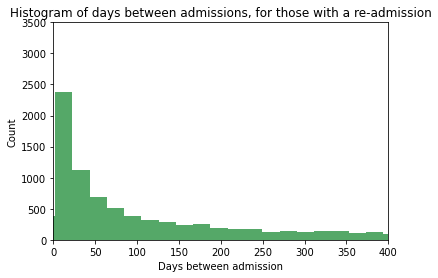

In [ ]:
# plt.bar(df_adm['DAYS_NEXT_ADMIT'], df_adm['SUBJECT_ID'], color='green')
plt.hist(df_adm['DAYS_NEXT_ADMIT'], bins=200, color = '#55a868')
plt.xlim(0, 400)
plt.ylim(0,3500)
plt.title('Histogram of days between admissions, for those with a re-admission')
plt.ylabel('Count')
plt.xlabel('Days between admission')
plt.show()

# **Working with the NOTEEVENTS File**

In [ ]:
df_notes = pd.read_csv("/content/NOTEEVENTS.csv.gz")
df_notes.info()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2083180 entries, 0 to 2083179
Data columns (total 11 columns):
 #   Column       Dtype  
---  ------       -----  
 0   ROW_ID       int64  
 1   SUBJECT_ID   int64  
 2   HADM_ID      float64
 3   CHARTDATE    object 
 4   CHARTTIME    object 
 5   STORETIME    object 
 6   CATEGORY     object 
 7   DESCRIPTION  object 
 8   CGID         float64
 9   ISERROR      float64
 10  TEXT         object 
dtypes: float64(3), int64(2), object(6)
memory usage: 174.8+ MB


In [ ]:
# taking a look at the notes and how they are managed within the file
df_notes.iloc[2]
# filtering out only the discharge summaries
df_notes_dis_sum = df_notes.loc[df_notes.CATEGORY == 'Discharge summary']

In [ ]:
# filter to discharge summary
df_notes_dis_sum = df_notes.loc[df_notes.CATEGORY == 'Discharge summary']

In [ ]:
df_notes_dis_sum_last = (df_notes_dis_sum.groupby(['SUBJECT_ID','HADM_ID']).nth(-1)).reset_index()
assert df_notes_dis_sum_last.duplicated(['HADM_ID']).sum() == 0, 'Multiple discharge summaries per admission'

In [ ]:
df_adm_notes = pd.merge(df_adm[['SUBJECT_ID','HADM_ID','ADMITTIME','DISCHTIME','DAYS_NEXT_ADMIT','NEXT_ADMITTIME','ADMISSION_TYPE','DEATHTIME']],
                        df_notes_dis_sum_last[['SUBJECT_ID','HADM_ID','TEXT']], 
                        on = ['SUBJECT_ID','HADM_ID'],
                        how = 'left')
assert len(df_adm) == len(df_adm_notes), 'Number of rows increased'

In [ ]:
df_adm_notes.groupby('ADMISSION_TYPE').apply(lambda g: g.TEXT.isnull().sum())/df_adm_notes.groupby('ADMISSION_TYPE').size()

ADMISSION_TYPE
ELECTIVE     0.048663
EMERGENCY    0.037983
NEWBORN      0.536691
URGENT       0.042665
dtype: float64

In [ ]:
df_adm_notes.to_csv(index=False)
pd.DataFrame(df_adm_notes).to_csv("/content/dfADMNotes.csv")

In [ ]:
df_adm_notes1 = pd.read_csv("/content/dfADMNotes.csv")
df_adm_notes1.iloc[1]

Unnamed: 0                                                         1
SUBJECT_ID                                                         3
HADM_ID                                                       145834
ADMITTIME                                        2101-10-20 19:08:00
DISCHTIME                                        2101-10-31 13:58:00
DAYS_NEXT_ADMIT                                                  NaN
NEXT_ADMITTIME                                                   NaN
ADMISSION_TYPE                                             EMERGENCY
DEATHTIME                                                        NaN
TEXT               Admission Date:  [**2101-10-20**]     Discharg...
Name: 1, dtype: object

Remove Newborn rows

In [ ]:
df_adm_notes1.drop(df_adm_notes1[ df_adm_notes1['ADMISSION_TYPE'] == 'NEWBORN' ].index, inplace = True)

In [ ]:
df_adm_notes1.iloc[0]

Unnamed: 0                                                         1
SUBJECT_ID                                                         3
HADM_ID                                                       145834
ADMITTIME                                        2101-10-20 19:08:00
DISCHTIME                                        2101-10-31 13:58:00
DAYS_NEXT_ADMIT                                                  NaN
NEXT_ADMITTIME                                                   NaN
ADMISSION_TYPE                                             EMERGENCY
DEATHTIME                                                        NaN
TEXT               Admission Date:  [**2101-10-20**]     Discharg...
Name: 1, dtype: object

In [ ]:
df_adm_notes_clean= df_adm_notes1

In [ ]:
df_adm_notes_clean['OUTPUT_LABEL'] = (df_adm_notes_clean.DAYS_NEXT_ADMIT < 30).astype('int')

In [ ]:
# download df_adm_notes_clean for future reference
df_adm_notes_clean.to_csv(index=False)
pd.DataFrame(df_adm_notes_clean).to_csv("/content/dfAdmNotesClean.csv")

In [ ]:
# shuffle the samples
df_adm_notes_clean = df_adm_notes_clean.sample(n = len(df_adm_notes_clean), random_state = 42)
df_adm_notes_clean = df_adm_notes_clean.reset_index(drop = True)
# Save 30% of the data as validation and test data 
df_valid_test=df_adm_notes_clean.sample(frac=0.30,random_state=42)
df_test = df_valid_test.sample(frac = 0.5, random_state = 42)
df_valid = df_valid_test.drop(df_test.index)
# use the rest of the data as training data
df_train_all=df_adm_notes_clean.drop(df_valid_test.index)

In [ ]:
# split the training data into positive and negative
rows_pos = df_train_all.OUTPUT_LABEL == 1
df_train_pos = df_train_all.loc[rows_pos]
df_train_neg = df_train_all.loc[~rows_pos]
# merge the balanced data
df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos), random_state = 42)],axis = 0)
# shuffle the order of training samples 
df_train = df_train.sample(n = len(df_train), random_state = 42).reset_index(drop = True)

# **Preprocess the unstructured notes using scispaCy model approach**

In [ ]:
def preprocess_text(df):
    # This function preprocesses the text by filling not a number and replacing new lines ('\n') and carriage returns ('\r')
    df.TEXT = df.TEXT.fillna(' ')
    df.TEXT = df.TEXT.str.replace('\n',' ')
    df.TEXT = df.TEXT.str.replace('\r',' ')
    return df
# preprocess the text to deal with known issues
df_train = preprocess_text(df_train)
df_valid = preprocess_text(df_valid)
df_test = preprocess_text(df_test)

Create a function to extract entities using the scispaCy model

In [ ]:
import scispacy
import spacy
import en_ner_bc5cdr_md
import en_core_sci_lg
nlp = en_ner_bc5cdr_md.load()


/usr/local/lib/python3.6/dist-packages/spacy/util.py:275: UserWarning: [W031] Model 'en_core_sci_lg' (0.2.4) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.4). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [ ]:
def entityExtractor(text):
  tokens = list(nlp(text).ents)
  # print(tokens)
  return tokens

In [ ]:
# Testing how scispaCy works against word_tokenize (nltk)
import nltk
from nltk import word_tokenize
nltk.download('punkt')
word_tokenize('This should be tokenized. 02/02/2018 sentence has stars**')
text= 'This should be tokenized. 02/02/2018 sentence has stars**'
import string
def tokenizer_better(text):
    # tokenize the text by replacing punctuation and numbers with spaces and lowercase all words
    
    punc_list = string.punctuation+'0123456789'
    t = str.maketrans(dict.fromkeys(punc_list, " "))
    text = text.lower().translate(t)
    tokens = word_tokenize(text)
    return tokens
print('Rokenized Results: ')
print(tokenizer_better(df_train.loc[1,'TEXT']))
print('scispaCy Results: ')
print(list(nlp(df_train.loc[1,'TEXT']).ents))
print('Entity Extractor results')
print(entityExtractor(df_train.loc[1,'TEXT']))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Rokenized Results: 
['admission', 'date', 'discharge', 'date', 'service', 'neurosurgery', 'allergies', 'patient', 'recorded', 'as', 'having', 'no', 'known', 'allergies', 'to', 'drugs', 'attending', 'first', 'name', 'lf', 'chief', 'complaint', 'r', 'subdural', 'hemorrhage', 'major', 'surgical', 'or', 'invasive', 'procedure', 'none', 'history', 'of', 'present', 'illness', 'ym', 'tripped', 'and', 'fell', 'while', 'taking', 'out', 'trash', 'landed', 'on', 'face', 't', 'ferred', 'from', 'hospital', 'hosp', 'where', 'ct', 'head', 'showed', 'r', 'temporal', 'parietal', 'sdh', 'measuring', 'cm', 'ap', 'diameter', 'and', 'mm', 'in', 'thickness', 'there', 'is', 'no', 'mass', 'effect', 'seen', 'on', 'ct', 'patient', 'was', 'given', 'asa', 'for', 'cp', 'at', 'osh', 'and', 'later', 'given', 'u', 'ffp', 'to', 'reverse', 'past', 'medical', 'history', 'atrial', 'fibrillation', 'and', 'mi', 'social

Create a function for Count Vectorizer

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(max_features = 3000, tokenizer = entityExtractor)

vect.fit(df_train.TEXT.values)


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=3000, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function entityExtractor at 0x7f3935c01ea0>,
                vocabulary=None)

Transform data into numerical values

In [ ]:
X_train_tf = vect.transform(df_train.TEXT.values)
X_valid_tf = vect.transform(df_valid.TEXT.values)

In [ ]:
y_train = df_train.OUTPUT_LABEL
y_valid = df_valid.OUTPUT_LABEL

# **Predictive Model**

In [ ]:
# logistic regression
from sklearn.linear_model import LogisticRegression
clf=LogisticRegression(C = 0.0001, penalty = 'l2', random_state = 42)
clf.fit(X_train_tf, y_train)

LogisticRegression(C=0.0001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
model = clf
y_train_preds = model.predict_proba(X_train_tf)[:,1]
y_valid_preds = model.predict_proba(X_valid_tf)[:,1]

In [ ]:
print(y_train[:10].values)
print(y_train_preds[:10])

[1 1 0 1 1 1 0 0 1 1]
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]


**Model** **Quality**

In [ ]:
#Prevalence, Accuracy, Recall(Sensitivity), Specifity, Precision

def calc_accuracy(y_actual, y_pred, thresh):
    # this function calculates the accuracy with probability threshold at thresh
    return (sum((y_pred > thresh) & (y_actual == 1))+sum((y_pred <thresh) & (y_actual == 0))) /len(y_actual)

def calc_recall(y_actual, y_pred, thresh):
    # calculates the recall
    return sum((y_pred > thresh) & (y_actual == 1)) /sum(y_actual)

def calc_precision(y_actual, y_pred, thresh):
    # calculates the precision
    return sum((y_pred > thresh) & (y_actual == 1)) /sum(y_pred > thresh)

def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def calc_prevalence(y_actual):
    # calculates prevalence
    return sum((y_actual == 1)) /len(y_actual)

Train AUC:0.500
Valid AUC:0.500
Train accuracy:0.000
Valid accuracy:0.000
Train recall:0.000
Valid recall:0.000
Train precision:nan
Valid precision:nan
Train specificity:0.000
Valid specificity:0.000
Train prevalence:0.500
Valid prevalence:0.057


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]


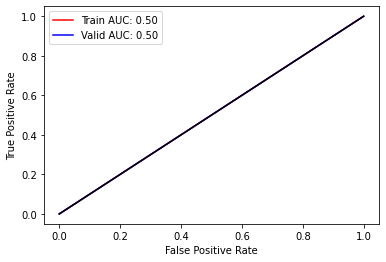

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)


thresh = 0.5

auc_train = roc_auc_score(y_train, y_train_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

print('Train AUC:%.3f'%auc_train)
print('Valid AUC:%.3f'%auc_valid)

print('Train accuracy:%.3f'%calc_accuracy(y_train, y_train_preds, thresh))
print('Valid accuracy:%.3f'%calc_accuracy(y_valid, y_valid_preds, thresh))


print('Train recall:%.3f'%calc_recall(y_train, y_train_preds, thresh))
print('Valid recall:%.3f'%calc_recall(y_valid, y_valid_preds, thresh))

print('Train precision:%.3f'%calc_precision(y_train, y_train_preds, thresh))
print('Valid precision:%.3f'%calc_precision(y_valid, y_valid_preds, thresh))

print('Train specificity:%.3f'%calc_specificity(y_train, y_train_preds, thresh))
print('Valid specificity:%.3f'%calc_specificity(y_valid, y_valid_preds, thresh))

print('Train prevalence:%.3f'%calc_prevalence(y_train))
print('Valid prevalence:%.3f'%calc_prevalence(y_valid))


plt.plot(fpr_train, tpr_train,'r-', label = 'Train AUC: %.2f'%auc_train)
plt.plot(fpr_valid, tpr_valid,'b-',label = 'Valid AUC: %.2f'%auc_valid)
plt.plot([0,1],[0,1],'-k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# **TSNE & Word2Vec for first 50 notes**

In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import re
import nltk

from gensim.models import word2vec

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Build corpus
corpus=[]
for row in range(0, 51):
  str_tokens=[]
  tokens= nlp(df_train.loc[row, 'TEXT']).ents
  for i in range(0, len(tokens)):
    str_tokens.append(tokens[i].text)
  corpus.append(list(str_tokens))
  

print(corpus)



[['**2144-5-6**', '**2144-5-12**', '**2096-7-8**', 'Zyban  ', 'carcinoma of the right lung', 'mediastinal mass', 'gortex', 'carcinoma', 'vena caval syndrome', 'RUL', 'NAD', 'SVC syndrome', 'CTA', 'COR', 'hydropneumothorax', 'fibrosis', 'pleural effusion', '**2144-5-8**', 'atelectasis', 'hematoma', 'hydropneumothorax', 'tube/drains', 'atelectasis', 'pneumonitis', 'left back sebaceous cyst', '**2144-5-11**', 'Glucose', 'Na K', 'Pt', 'Pt', 'pain', 'Aspirin', 'Metoprolol Tartrate', 'fever', 'chills', 'chest pain', 'shortness of breath', 'Name 4738**] [**Telephone/Fax'], ['Allergies', 'Subdural hemorrhage  ', 'CP', 'Atrial fibrillation', 'WD/WN', 'NAD', 'dysarthria', 'paraphasic', 'Extraocular movements', 'nystagmus', 'fasciculations', 'abnormal movements', 'tremors', 'RBC-3.72', 'AnGap-15', 'CK-MB-NotDone', 'hematoma', 'herniation', 'herniation', 'acute infarction', 'fracture', 'Cspine', 'fractures', 'dislocations', 'subdural hematoma', 'subdural hemorrhage', 'hemorrhage', 'Dilantin', 'sei

In [ ]:

model = word2vec.Word2Vec(corpus, min_count=1)
model.wv['carcinoma']


array([ 2.4149653e-03, -2.0504938e-03, -1.1668251e-03,  1.6675551e-03,
       -3.5528082e-04, -4.5012743e-03,  4.3414836e-03, -4.7143446e-03,
        2.0006429e-03,  3.4040741e-03, -1.8720542e-03, -4.6487572e-03,
        3.7923523e-03, -1.0832562e-03,  5.6054292e-04,  4.1486678e-04,
       -2.5754727e-03, -4.6006483e-03, -2.6972634e-03,  3.8410837e-03,
       -2.1884439e-03,  3.6942223e-03,  6.1474486e-05, -1.0562176e-03,
       -1.1531159e-03, -1.2281103e-03,  2.4338749e-04,  1.9167493e-03,
        3.3249236e-03, -2.8144906e-03,  1.4487723e-03,  2.0035759e-03,
        1.0982574e-03,  4.0039876e-03,  3.7401225e-03,  1.7259328e-04,
        1.1551589e-03, -1.4108504e-03,  2.0204160e-04,  2.9864270e-04,
       -9.3457557e-04,  1.3230828e-03, -3.0471261e-03,  1.3439609e-03,
       -3.7705710e-03,  3.8653854e-03, -2.4904045e-03,  3.0417580e-03,
        1.9844339e-04,  2.9162504e-03, -2.9137677e-03, -6.6409830e-04,
       -1.2107078e-03, -4.6164179e-03, -3.0146628e-03,  2.0863416e-05,
      

In [ ]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=50, early_exaggeration=50, n_components=3, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [ ]:
tsne_plot(model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


KeyboardInterrupt: ignored

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


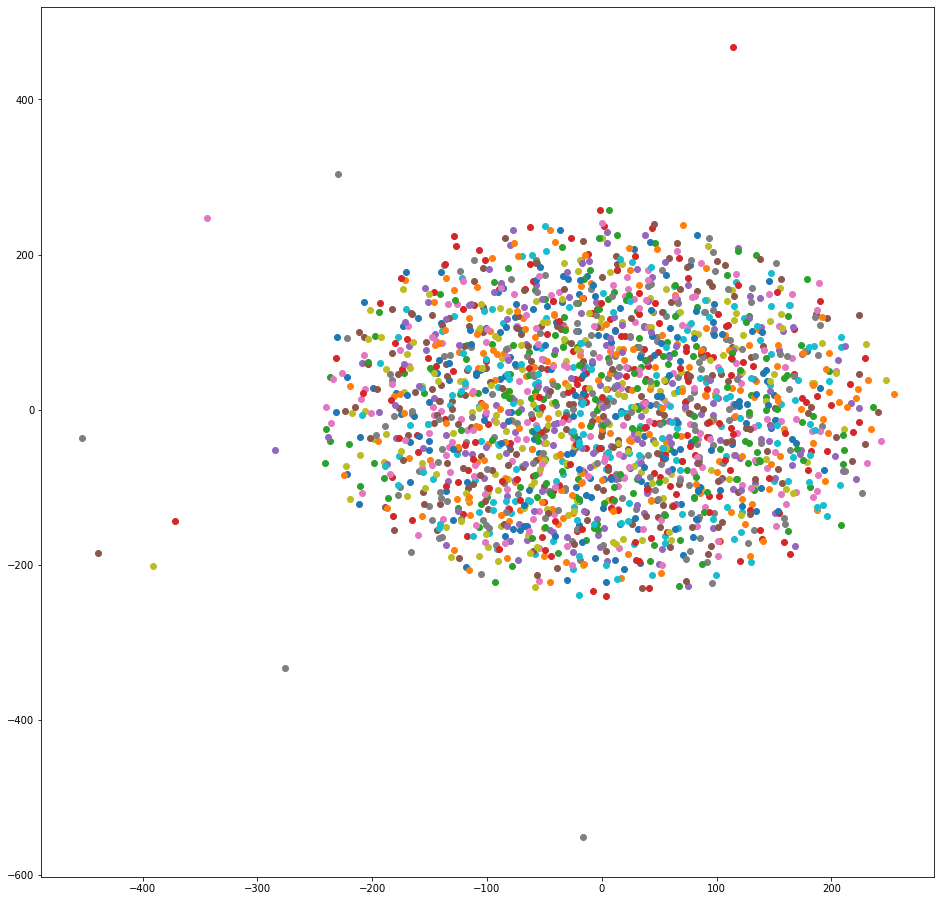

In [ ]:
# A more selective model
model = word2vec.Word2Vec(corpus, size=51, window=20, min_count=1, workers=4)
tsne_plot(model)